Here, we aim to demonstrate the hypernomy in the cognitive control literature.

In [5]:
# imports and load the topic weights
# keep only popular constructs

%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix
from python.cogtext.plotting.rose_plot import rose_plot

# load the data
# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/gpt3/abstracts_gpt3ada_clusters.csv.gz', index_col=0)
weights = np.load('models/gpt3/abstracts_gpt3ada_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)


n_popular_labels = 50

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())

pubmed = pubmed.query('pmid.notna() and abstract.notna()')
pubmed = pubmed.query('label in @popular_labels')

In [6]:
# assign documents to scientific communities

comm_cognit = pubmed.query('journal_title.str.contains("cogn",case=False)')
comm_neuros = pubmed.query('journal_title.str.contains("neur",case=False)')
comm_psycho = pubmed.query('journal_title.str.contains("psych",case=False)')
comm_social = pubmed.query('journal_title.str.contains("social",case=False)')

pubmed.loc[comm_cognit.index, 'scientific_community'] = 'cognitive'
pubmed.loc[comm_neuros.index, 'scientific_community'] = 'neuroscience'
pubmed.loc[comm_psycho.index, 'scientific_community'] = 'psychology'
pubmed.loc[comm_social.index, 'scientific_community'] = 'social'

# discard the rest
pubmed.dropna(subset=['scientific_community'], inplace=True)

print(f'Analyzing {len(pubmed)} documents...')

Analyzing 136746 documents...


In [7]:
# label embeddings (max-pooling)

def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]

def create_label_embeddings(df):
  label_embeddings = \
    df.groupby('label')['weights'].apply(lambda x: np.max(np.stack(x.values), axis=0))

  label_embeddings = pd.DataFrame(np.stack(label_embeddings), index=label_embeddings.index)
  label_embeddings['category'] = label_embeddings.index.to_series().apply(find_category_by_label)
  label_embeddings.set_index(['category'], append=True, inplace=True)

  return label_embeddings

def create_task_construct_matrix(df, metric='kl', normalize=False):  
  embeddings = create_label_embeddings(df)
  sim_df = get_similarity_matrix(
    embeddings,
    metric=metric,
    pivot_by_category=True)
  sim_df.columns.name = 'task'
  sim_df.index.name = 'construct'

  if normalize:
    sim_df = sim_df.div(sim_df.sum(axis=1), axis=0)

  return sim_df


def plot_hypernomy(label, df):
  comm_embeddings = df.query('construct == @label').stack().reset_index()
  comm_embeddings.rename(columns={0:'weight'}, inplace=True)

  _, ax = plt.subplots(figsize=(35,6))
  sns.set('poster')
  sns.barplot(hue='scientific_community', y='weight', x='task', data=comm_embeddings)

  plt.xticks(rotation=90, ha='center')
  # plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

  ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fancybox=True, shadow=False)
  plt.suptitle(f'"{label}" hypernomy across scientific communities', y= 1.05)
  plt.show()

In [23]:
sim_df = pubmed.groupby('scientific_community').apply(create_task_construct_matrix, metric='cosine')

constructs = ['Attention', 'WorkingMemory', 'RewardProcessing', 'CogntiveControl']

popular_tasks = sim_df.sum(axis=0).sort_values(ascending=False).index[:10].to_list()


In [155]:
d = sim_df.query('construct == "CogntiveControl"').T
d.columns = d.columns.droplevel(1)
d = d.sort_values(by='psychology', ascending=False).reset_index()
ordered_cols = d['task'].to_list()

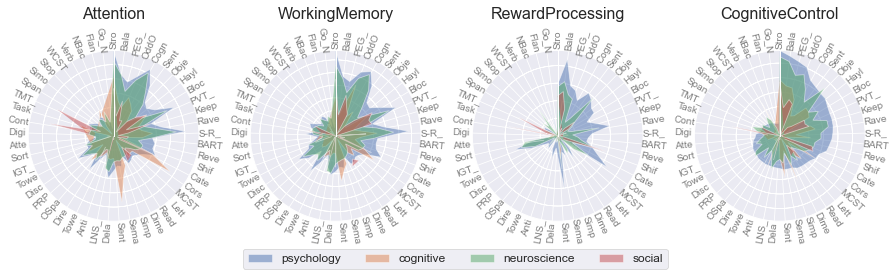

In [185]:
sns.set('paper')
fig, axes = plt.subplots(1,4,figsize=(15,15),
                         gridspec_kw={'wspace': 0.3},
                         subplot_kw=dict(projection='polar'))

for i,construct in enumerate(constructs):
  ax = axes.flatten()[i]
  data = sim_df.query('construct == @construct')[ordered_cols].T
  data.columns = data.columns.droplevel(1)
  # reorder columns
  psychology_col = data.pop('psychology')
  data.insert(0, 'psychology', psychology_col)
  # neuroscience_col = data.pop('neuroscience')
  # data.insert(1, 'neuroscience', neuroscience_col)
  # data = data.sort_values(by='psychology', ascending=False).reset_index()
  data = data.reset_index()
  rose_plot(data, ax=ax, alpha=0.5, fontsize=10)
  
  # FIXME to fix a typo in the lexion ("CogntiveControl")
  construct = construct.replace('Cogntive','Cognitive')

  ax.set_title(construct, fontsize=16, y=1.15)

# improve overall aesthetics
# axes.flatten()[-1].set_axis_off()
handles, labels = axes.flatten()[0].get_legend_handles_labels()
plt.legend(handles, labels,
           fontsize=12,
           loc='center', bbox_to_anchor=(-1.4, -.22), ncol=4, fancybox=True, shadow=False)

plt.show()

In [ ]:
# create task-signature for the most popular constructs

kl_df = pubmed.groupby('scientific_community').apply(create_task_construct_matrix, metric='kl')
sim_df = pubmed.groupby('scientific_community').apply(create_task_construct_matrix, metric='cosine')

2021-12-15 12:45:42.576720: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


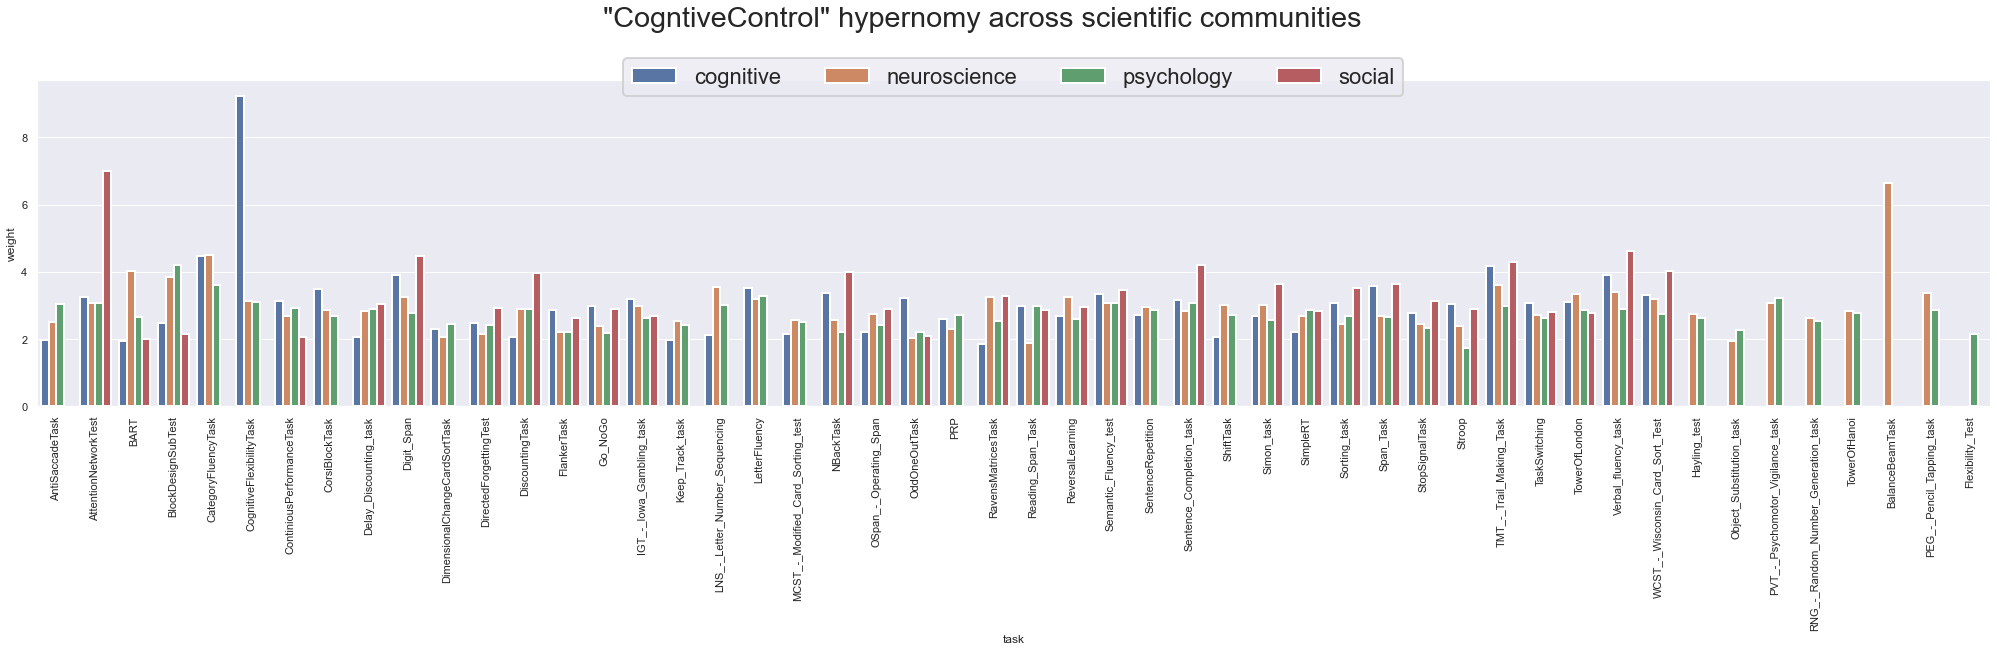

In [ ]:
plot_hypernomy('CogntiveControl', kl_df.applymap(lambda x: x if x < 100 else np.nan))

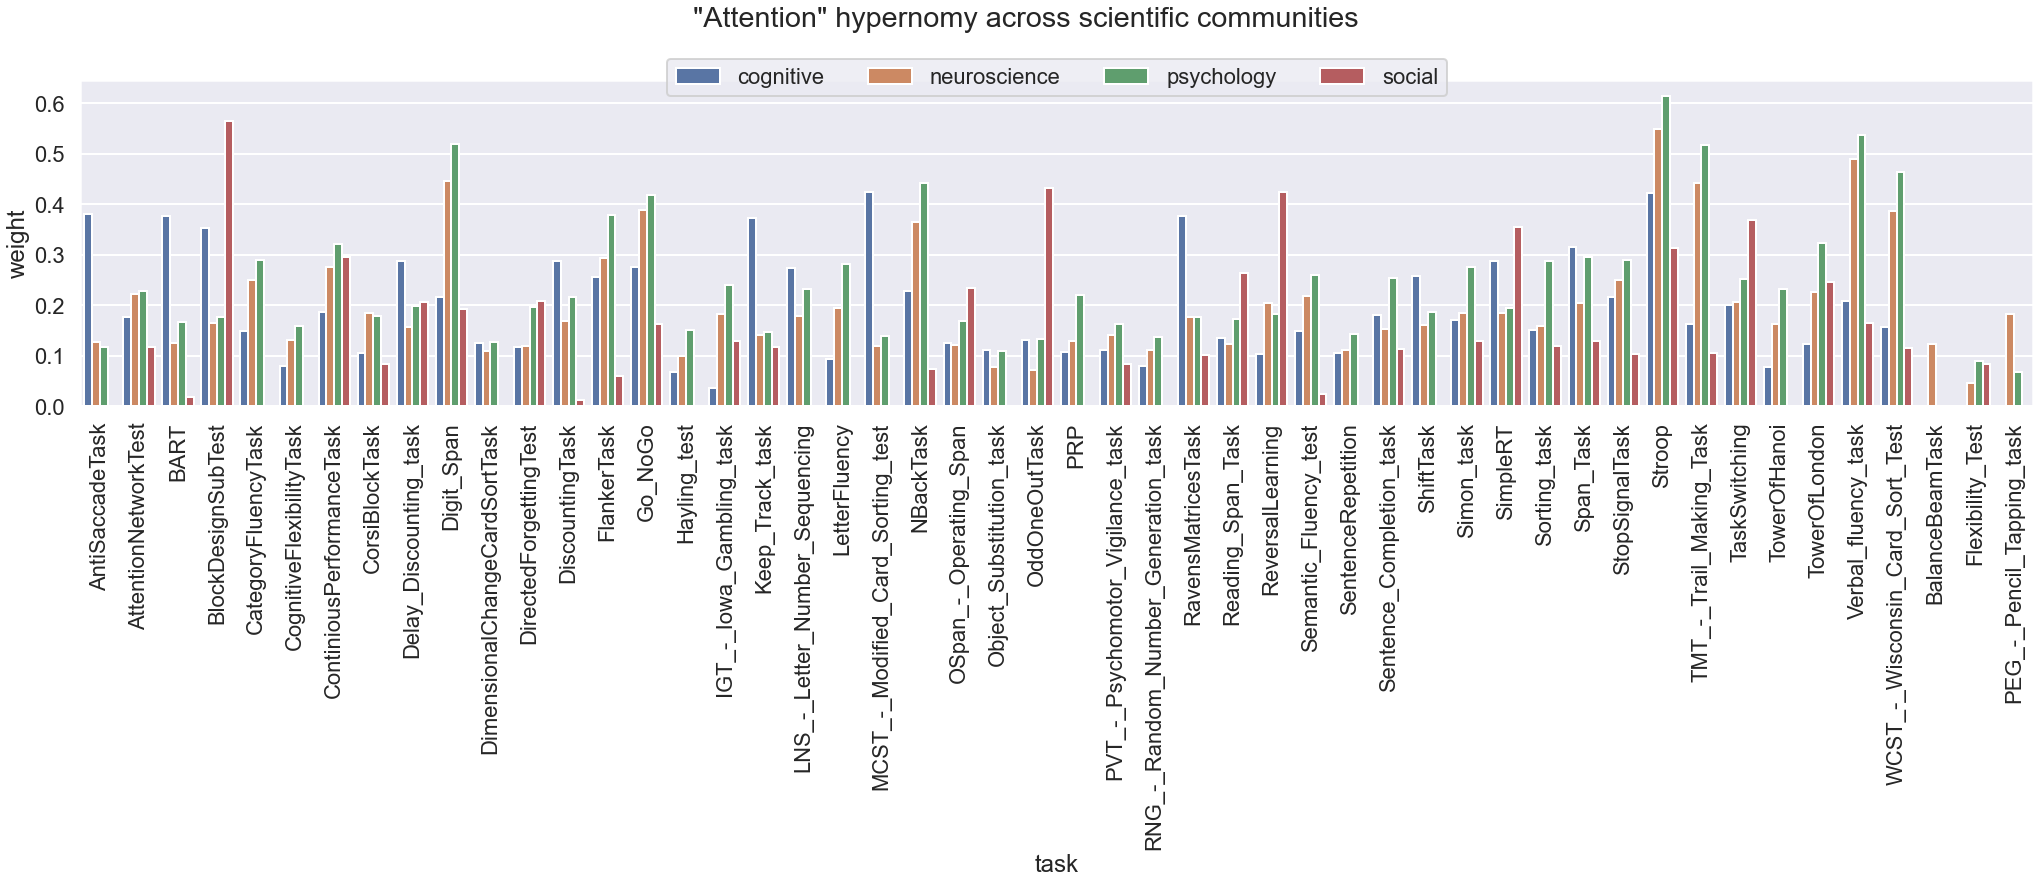

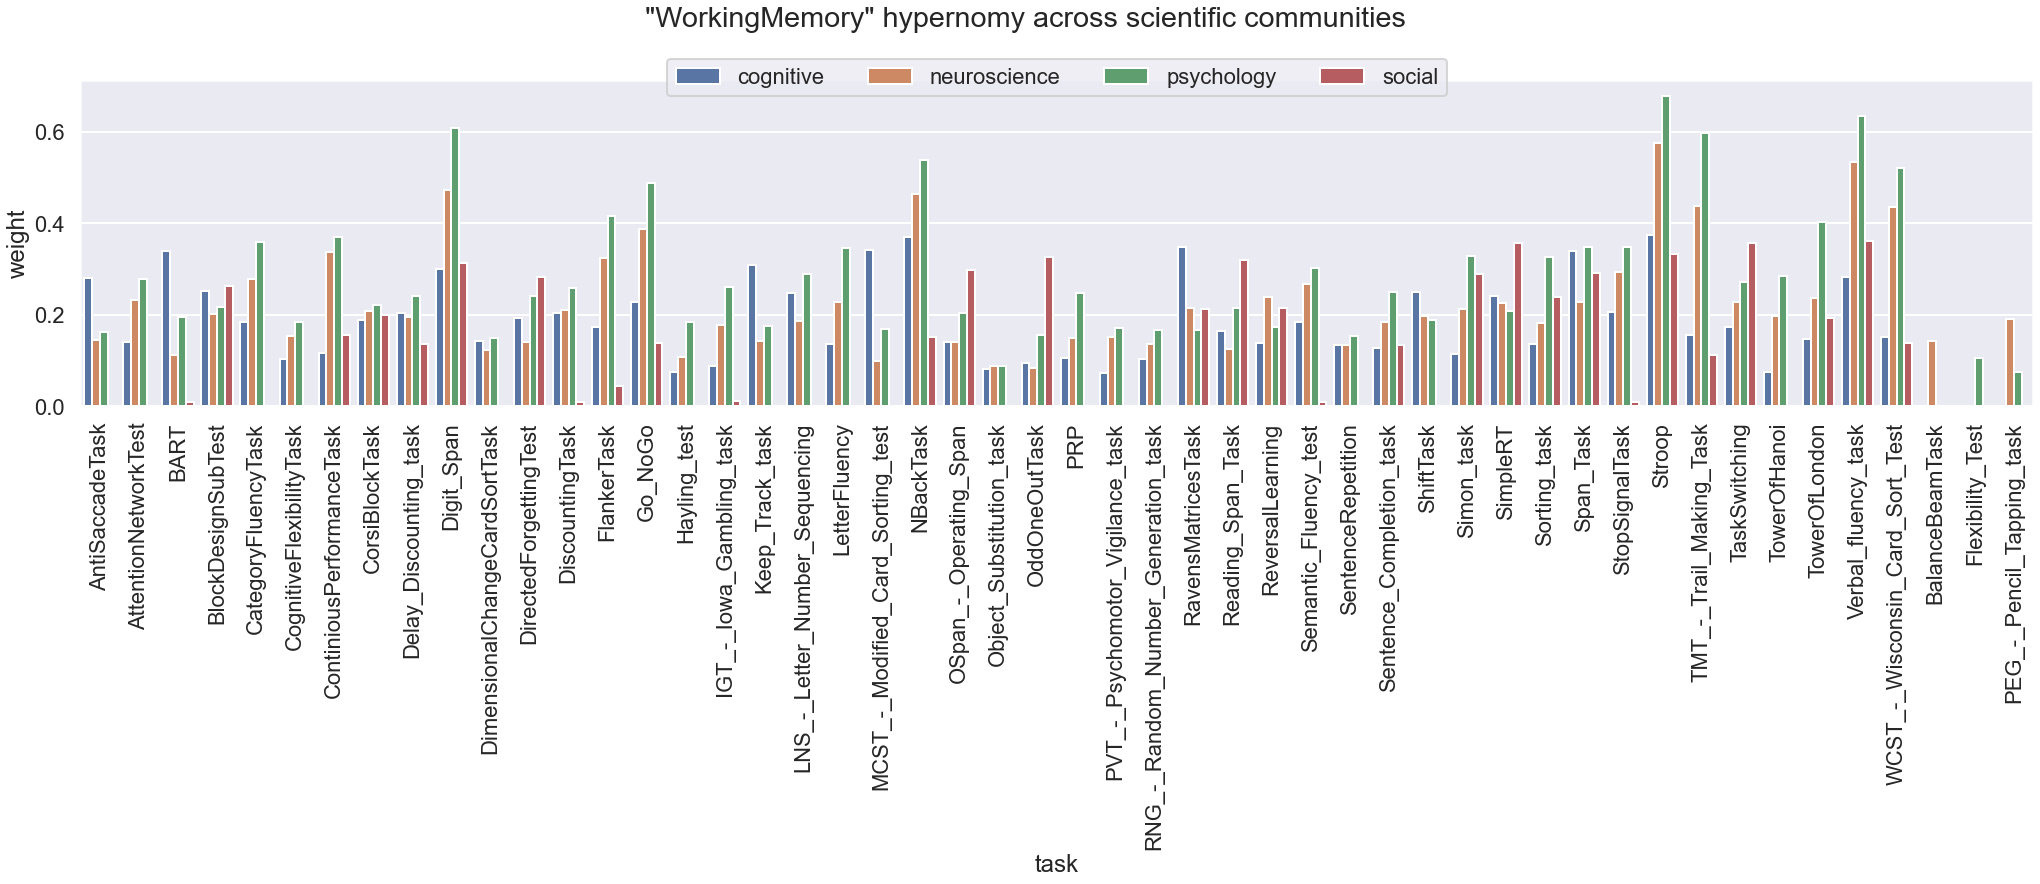

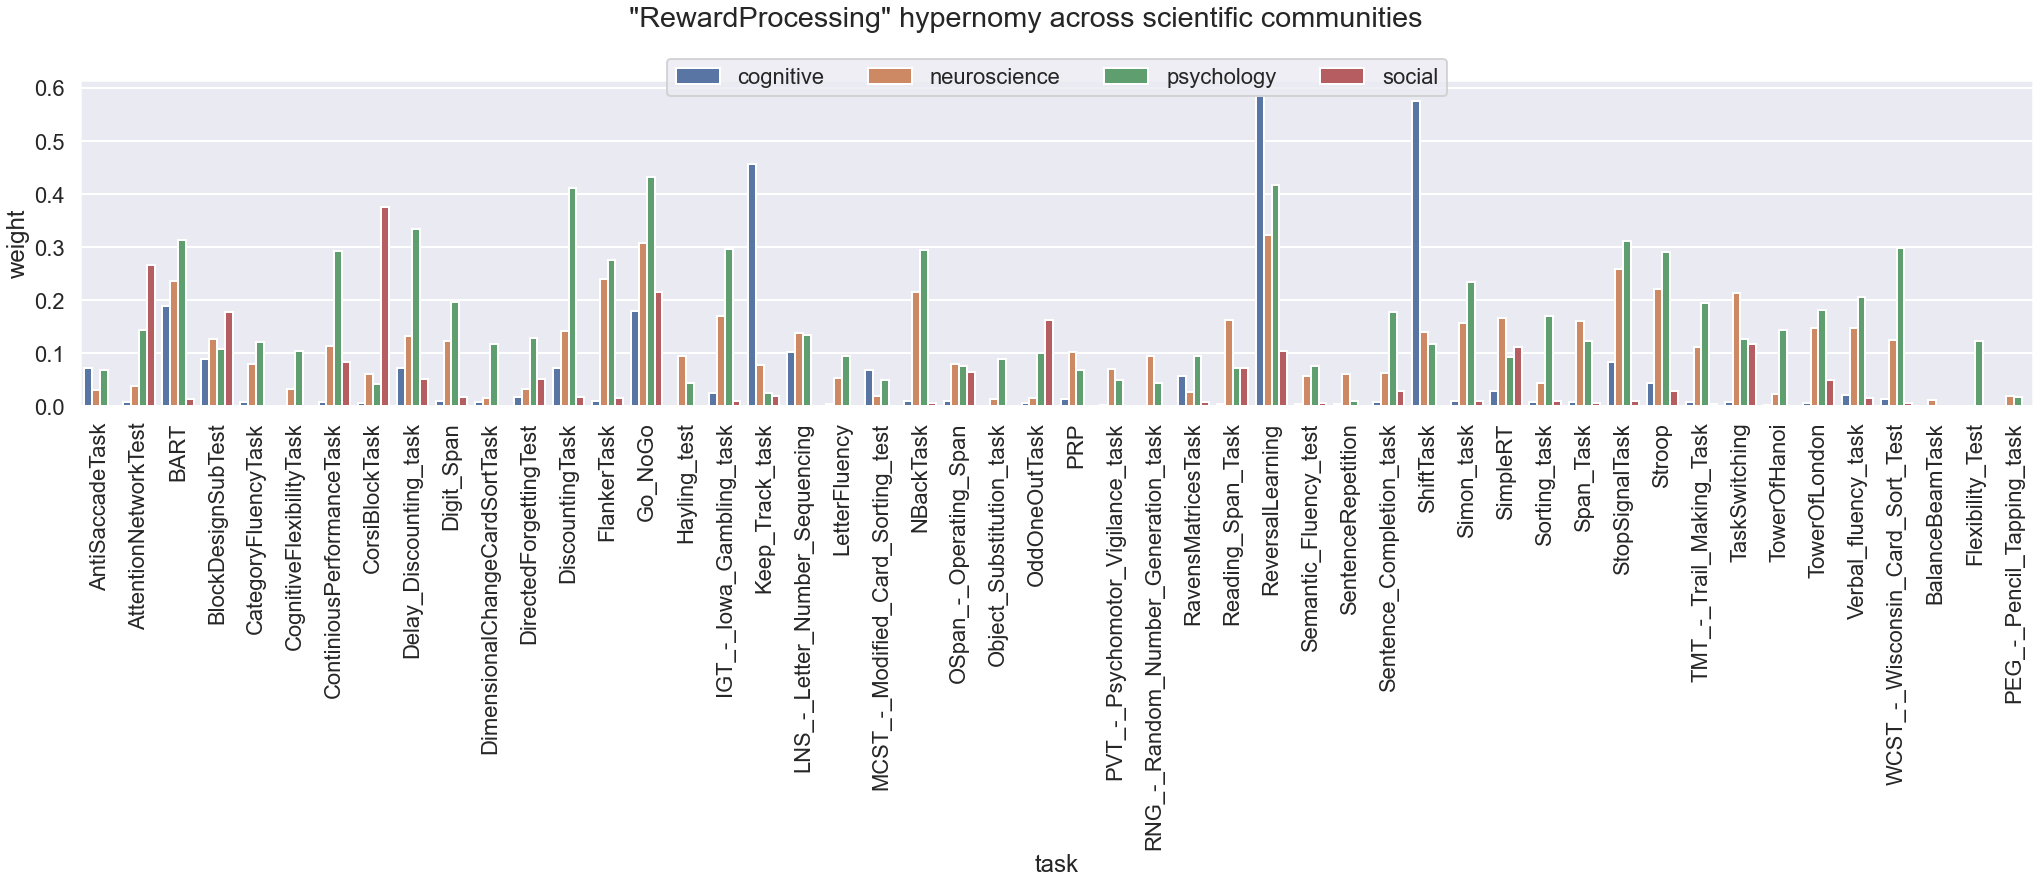

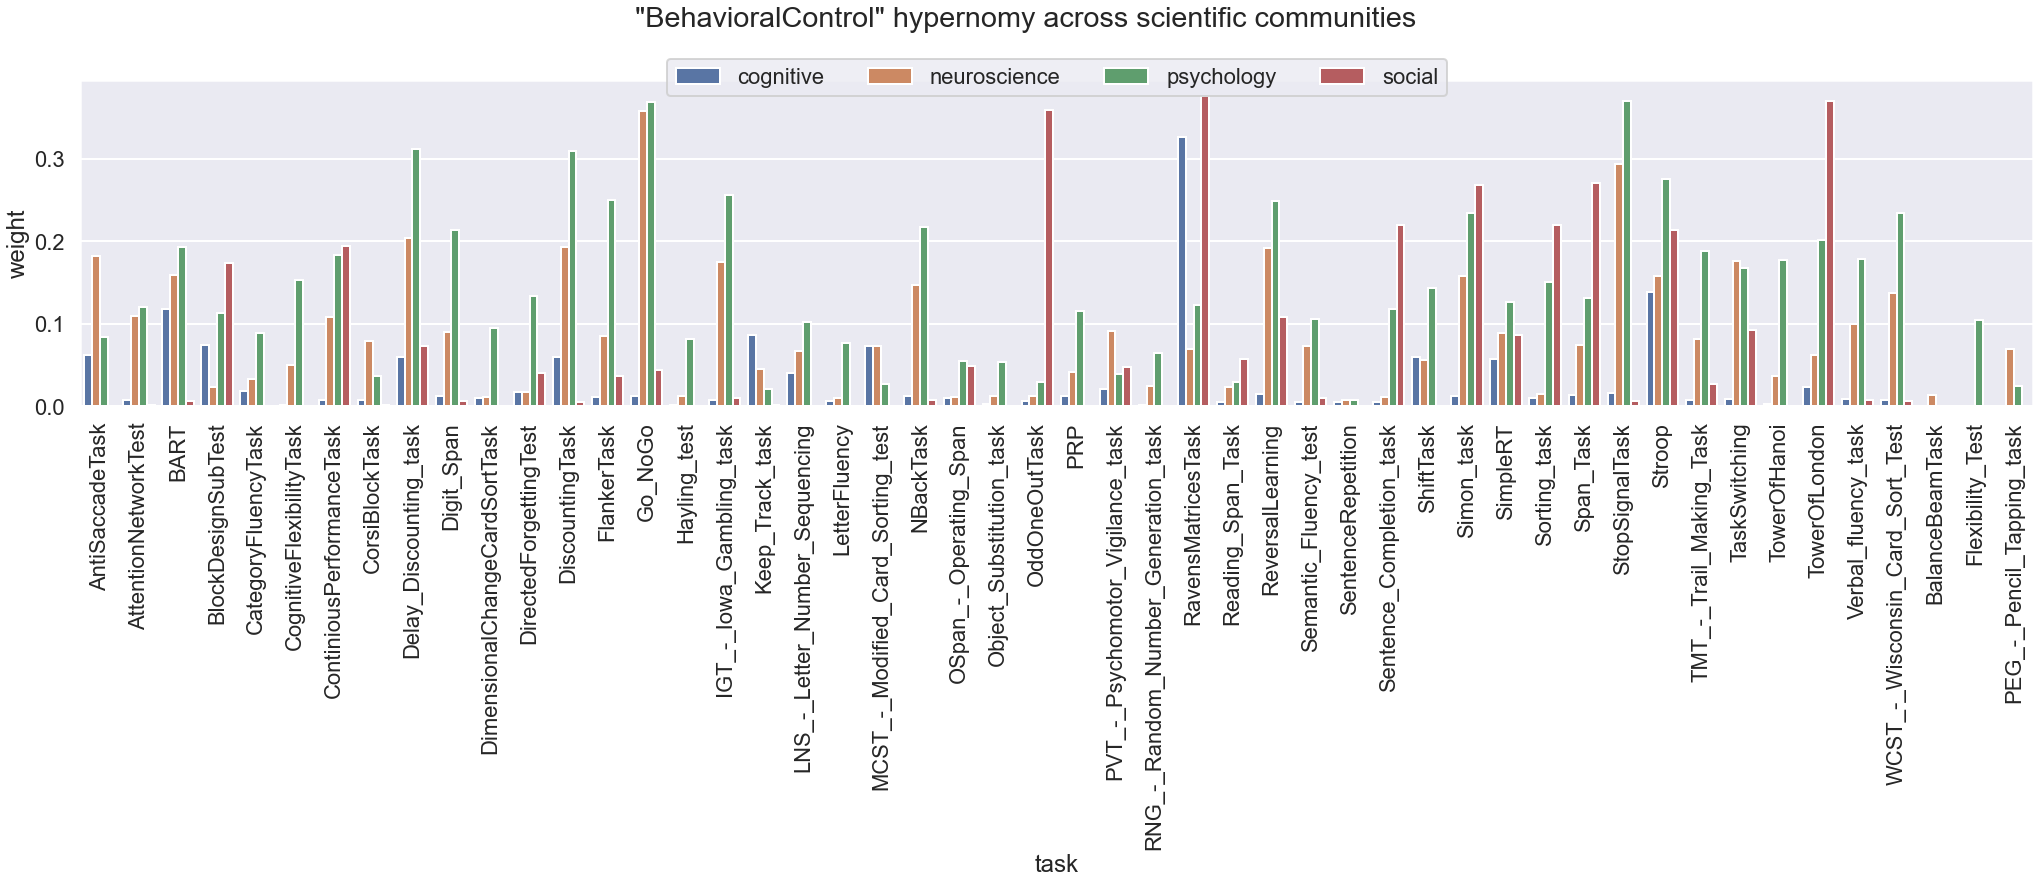

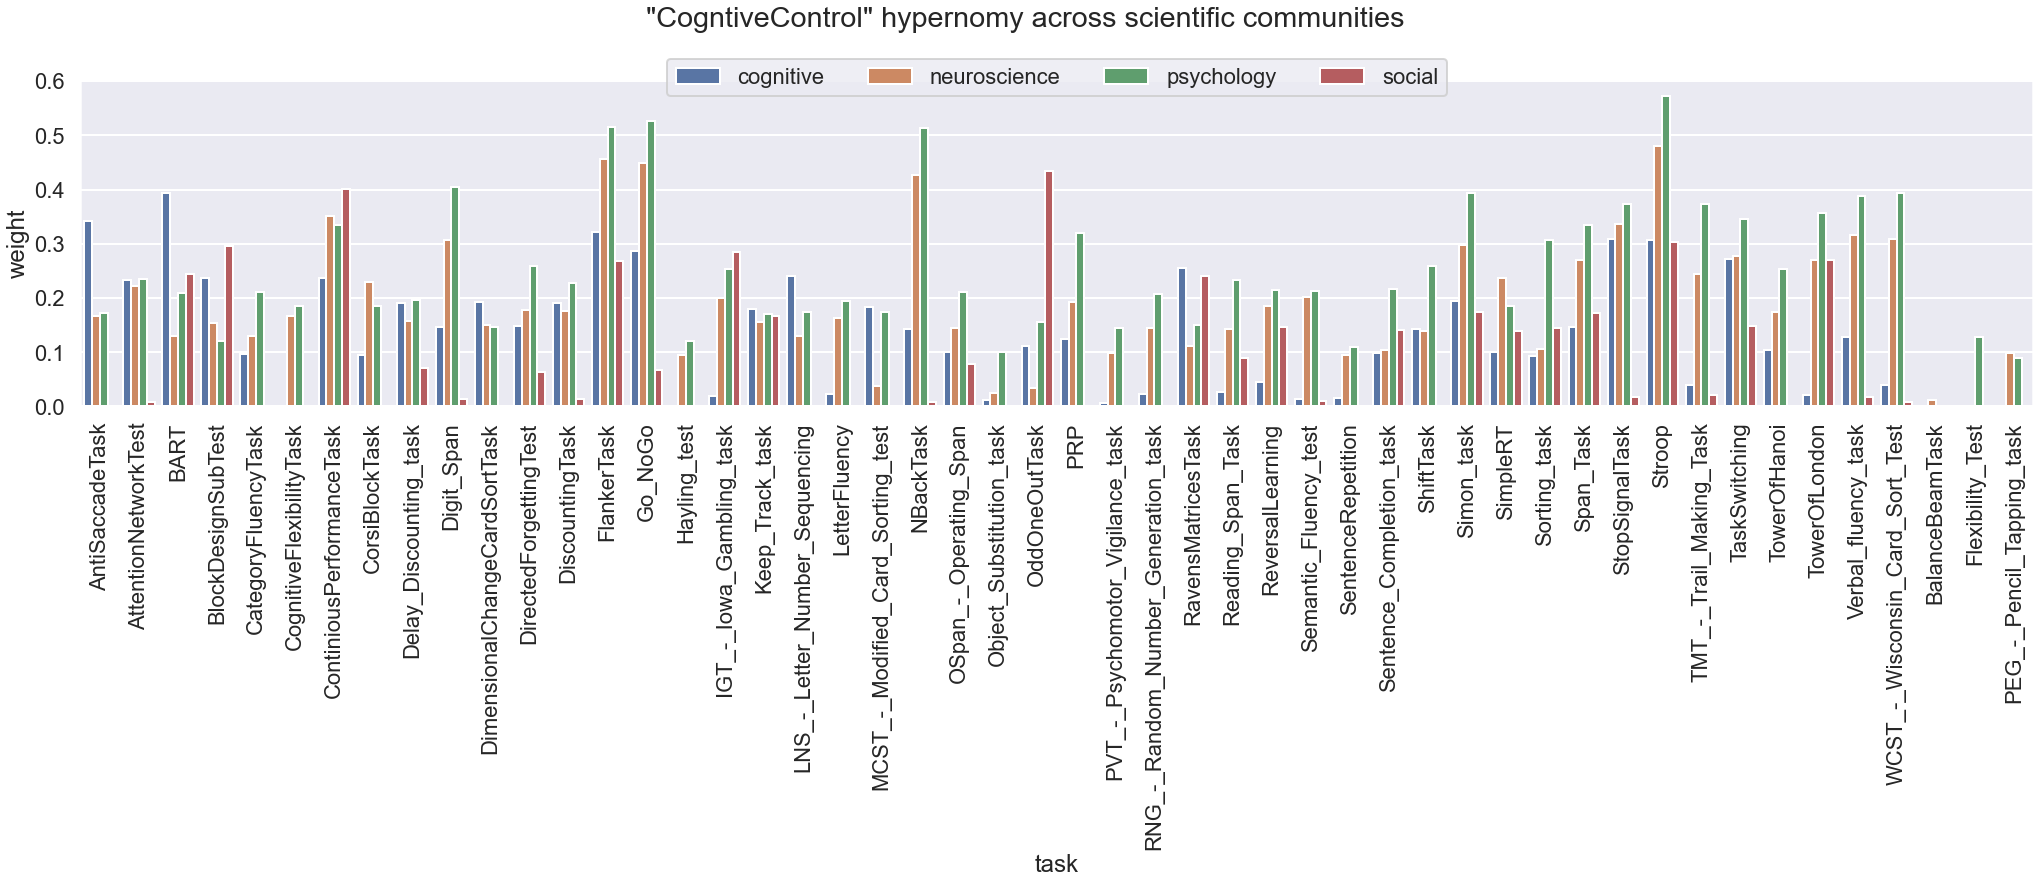

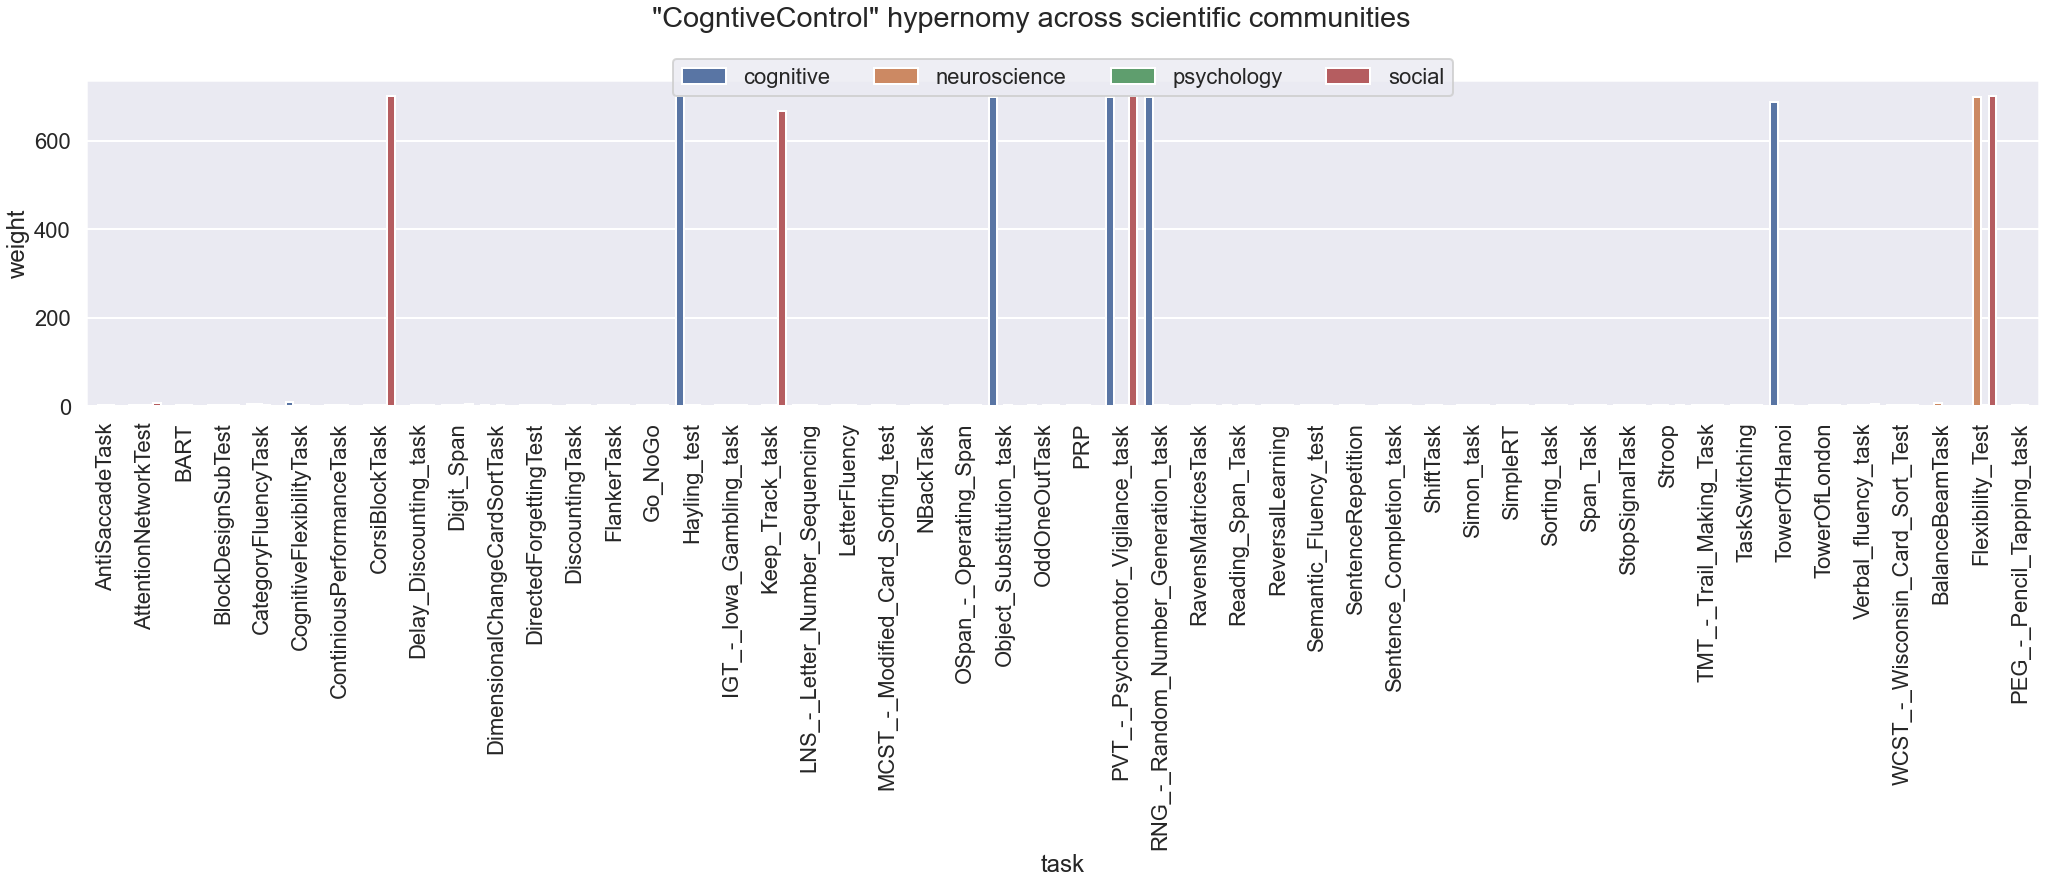

In [ ]:
# plot histograms of constructs across scientific communities

plot_hypernomy('Attention', sim_df)
plot_hypernomy('WorkingMemory', sim_df)
plot_hypernomy('RewardProcessing', sim_df)
plot_hypernomy('BehavioralControl', sim_df)
plot_hypernomy('CogntiveControl', sim_df)
plot_hypernomy('CogntiveControl', kl_df)

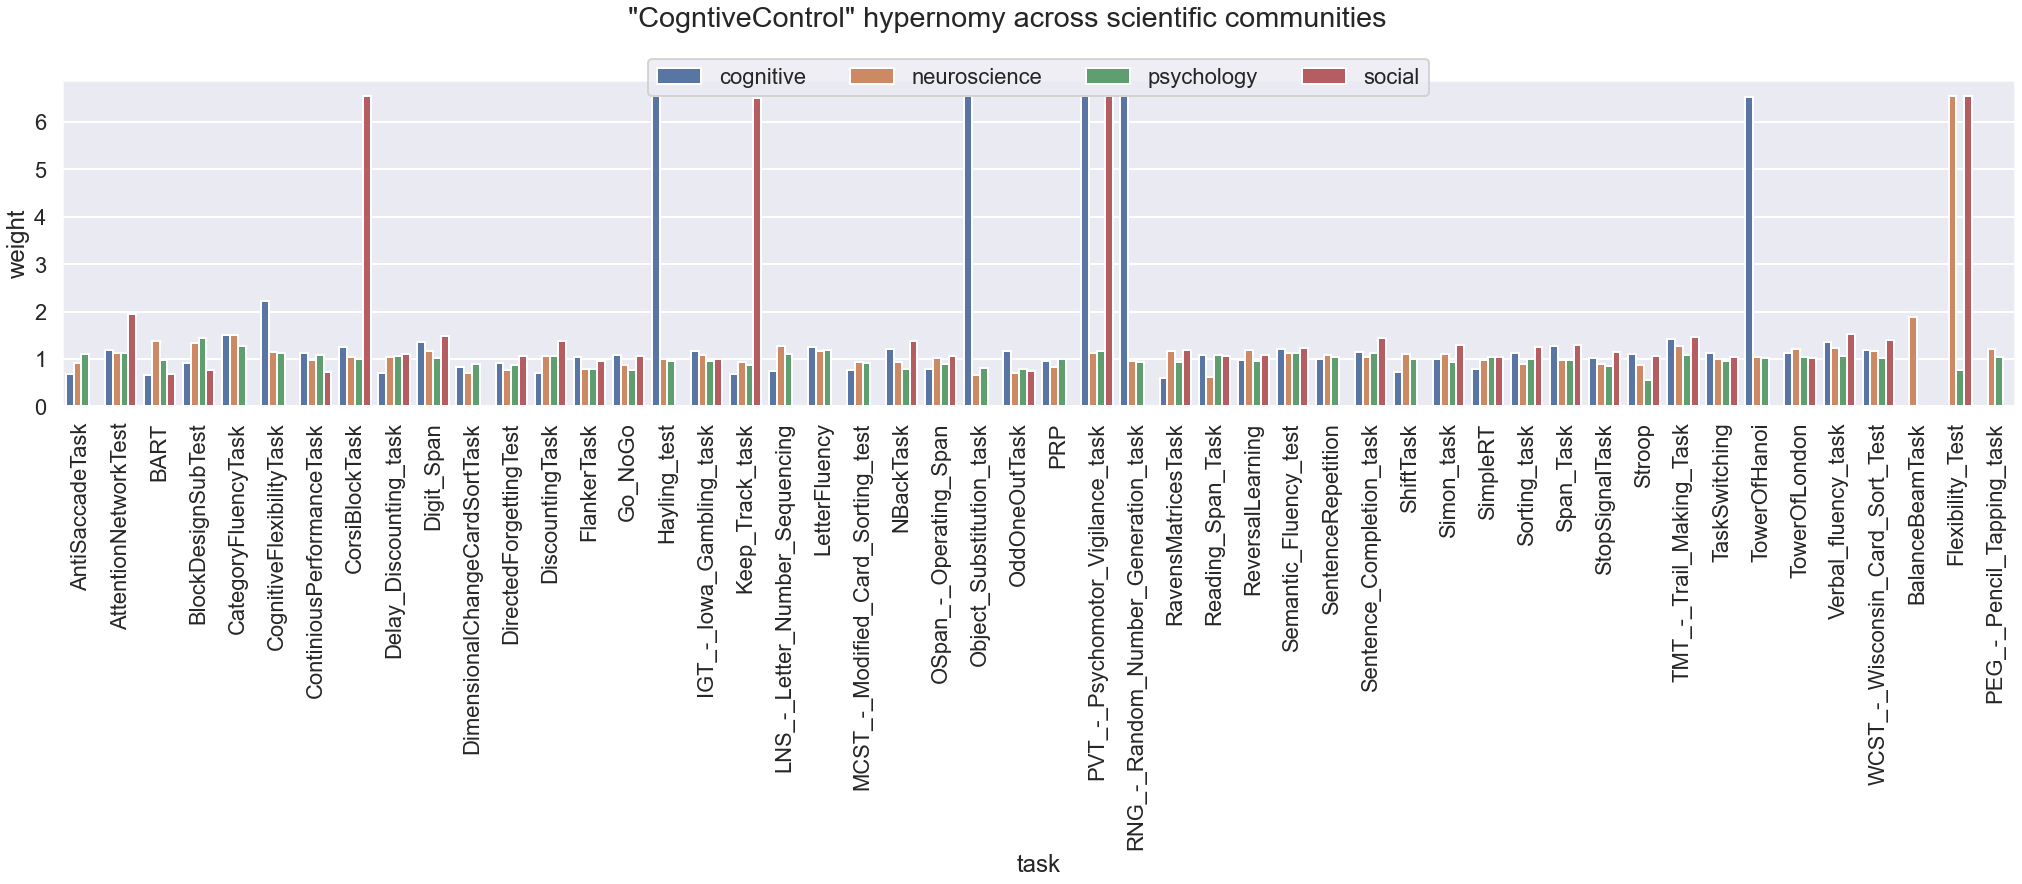

In [ ]:
plot_hypernomy('CogntiveControl', kl_df.applymap(lambda x: np.log(x)))